In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from glob import glob
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import sys
sys.path.append('../functions/')

from adjust_lon_xr_dataset import adjust_lon_xr_dataset
from convert_era5_to_Wm2 import convert_era5_to_Wm2

from map_plotting import southern_ocean_map
import cartopy
import cartopy.crs as ccrs

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


To identify all the indices within a 500 km radius of a specific point (50°S, 0°E) using latitude and longitude data from ERA5, you can follow these steps:

Convert Coordinates to Radians: Since trigonometric functions in most programming languages use radians, convert your latitude and longitude values from degrees to radians.

Calculate the Distance: Use the Haversine formula to calculate the distance between two points on the Earth's surface. The formula is:

$$ d = 2r \arcsin\left(\sqrt{\sin^2\left(\frac{\Delta \phi}{2}\right) + \cos(\phi_1) \cos(\phi_2) \sin^2\left(\frac{\Delta \lambda}{2}\right)}\right) $$

where:
    ( d ) is the distance between the two points.
    ( r ) is the Earth's radius (mean radius = 6,371 km).
    ( \phi_1, \phi_2 ) are the latitudes of the two points in radians.
    ( \Delta \phi ) is the difference between the latitudes.
    ( \Delta \lambda ) is the difference between the longitudes.

Filter Points: Iterate through your list of coordinates and calculate the distance from each point to the reference point (50°S, 0°E). If the distance is less than or equal to 500 km, record the index.


In [ ]:
# import numpy as np

# def haversine(lat1, lon1, lat2, lon2):
#     R = 6371  # Earth radius in kilometers
#     lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
#     dlat = lat2 - lat1
#     dlon = lon2 - lon1
#     a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
#     c = 2 * np.arcsin(np.sqrt(a))
#     return R * c

In [2]:
def convert_longitude(longitude):
    if longitude < 0:
        return longitude + 360
    else:
        return longitude
    
def haversine(lat1, lon1, lat2, lon2):
    R1 = earth_radius(lat1)
    R2 = earth_radius(lat2)
    R = (R1 + R2) / 2  # Average radius for the two latitudes
    
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

def earth_radius(lat_radians):
    # Equatorial and polar radii in kilometers, insert latitude in radians
    a = 6378.137
    b = 6356.752
    R = np.sqrt(((a**2 * np.cos(lat_radians))**2 + (b**2 * np.sin(lat_radians))**2) / ((a * np.cos(lat_radians))**2 + (b * np.sin(lat_radians))**2))
    return R

def haversine_rad(lat1, lon1, lat2, lon2):
    R1 = earth_radius(lat1)  # insert latitude in radians
    R2 = earth_radius(lat2)  # insert latitude in radians
    R = (R1 + R2) / 2  # Average radius for the two latitudes
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

def get_idx_cyclone(lats, lons, ref_lat, ref_lon, radius=500):
    radius_array = np.full((len(lats), len(lons)), np.NaN)
    dist_array = np.zeros((len(lats), len(lons)))

    # Update the array with ones where the distance is within 500 km
    for i in range(len(lats)):
        for j in range(len(lons)):
            distance = haversine_rad(ref_lat, ref_lon, lats[i], lons[j])
            dist_array[i, j] = distance
            if distance <= radius:
                radius_array[i, j] = 1

    return radius_array, dist_array

In [ ]:
# def get_idx_cyclone(lats, lons, ref_lat, ref_lon, radius=500):

#     # Initialize the 2D array with zeros
#     radius_array = np.zeros((len(lats), len(lons)))*np.NaN

#     dist_array = np.ndarray([lats.size, lons.size])

#     distance_x = np.ndarray([lons.size])
#     distance_y = np.ndarray([lats.size])

#     # Update the array with ones where the distance is within 500 km
#     for i in range(len(lats)):
#         for j in range(len(lons)):
#             distance = haversine(ref_lat, ref_lon, lats[i], lons[j])
#             dist_array[i,j]=distance
#             if distance <= radius:
#                 radius_array[i][j] = 1  
        
#             if i==30:
#                 distance_x[j] = haversine(ref_lat, ref_lon, ref_lat, lons[j])

#                 if lons[j]<ref_lon:
#                     distance_x[j] = -distance_x[j]

#             if j==120:
#                 distance_y[i] = haversine(ref_lat, ref_lon, lats[i], ref_lon)                    

#                 if lats[i]<ref_lat:
#                     distance_y[i] = -distance_y[i]                

#     return radius_array, dist_array, distance_x, distance_y

In [ ]:
for yr in tqdm(range(1981, 2021)):
    
    stm = pd.read_csv('/Volumes/LaCie/Work/data/lodise2022_cyclones/SO_EC_tracks/SO_EC_tracks_' + str(yr) + '.csv')
    
    if yr == 1981:
        
        storms = stm
        
    else:

        stm['Storm ID'] = stm['Storm ID'] + storms['Storm ID'].max()
        
        storms = pd.concat([storms, stm])

ds_cyclones = storms.to_xarray()

ds_cyclones = ds_cyclones.assign_coords(TIME = ds_cyclones['Time'].astype(np.datetime64))
ds_cyclones = ds_cyclones.swap_dims({'index': 'TIME'})

ds_cyclones = ds_cyclones.rename({'Longitude': 'LONGITUDE',
                                  'Latitude': 'LATITUDE',
                                  'Storm ID': 'STORM_ID',
                                  'Minimum Pressure (hPa)': 'PRESSURE_MIN'})

ds_cyclones = ds_cyclones.drop(labels={'index', 'Time'})

ds_cyclones.attrs['dataset'] = 'Southern Ocean Extratropical Cyclone Tracks'
ds_cyclones.attrs['data source'] = 'https://github.com/jlodise/JGR2022_ExtratropicalCycloneTracker'
ds_cyclones.attrs['method'] = 'Lodise et al. 2022 - Global Climatology of Extratropical Cyclones From a New Tracking Approach and Associated Wave Heights from Satellite Radar Altimeter'
ds_cyclones.attrs['original data'] = 'ERA5 (https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era5)'

In [ ]:
# read in the cyclone dataset

ds_summer = ds_cyclones.sel(TIME=ds_cyclones.TIME.dt.season=="DJF")
ds_summer = ds_summer.isel(TIME=ds_summer.LATITUDE.data < -40)

In [ ]:
# read in the land sea mask from era5

lsm = xr.open_dataset('/Users/xduplm/Google Drive/My Drive/data/reanalysis/era5/land_sea_mask.nc')

lsm = adjust_lon_xr_dataset(lsm).sel(latitude=slice(-40, -90))

lsm_lats = lsm.latitude.values
lsm_lons = lsm.longitude.values


In [ ]:
# create lon/lat array where there is land (>0)

land_lons = []
land_lats = []

for i, lon in tqdm(enumerate(lsm_lons)):

    for j, lat in enumerate(lsm_lats):

        if lsm.sel(longitude=lon, latitude=lat).lsm > 0:

            land_lons += lon,
            land_lats += lat, 

land_lons = np.array(land_lons)
land_lats = np.array(land_lats)

In [ ]:
# remove bad lon and lats around islands - we don't want to lose too many cyclones

# south of aus & nz
idx = ((land_lons > 135) & (land_lons < 180) & (land_lats > -60) & (land_lats < -48))

land_lats = land_lats[~idx]
land_lons = land_lons[~idx]

# atlantic, indian
idx = ((land_lons > -62) & (land_lons < 135) & (land_lats > -63))

land_lats = land_lats[~idx]
land_lons = land_lons[~idx]

# west of nz
idx = ((land_lons > -180) & (land_lons < -160) & (land_lats > -70))

land_lats = land_lats[~idx]
land_lons = land_lons[~idx]

# ross sea
idx = ((land_lons > 155) & (land_lats > -68) & (land_lats < -50))

land_lats = land_lats[~idx]
land_lons = land_lons[~idx]

# abs
idx = ((land_lons > -135) & (land_lons < -76) & (land_lats > -70))

land_lats = land_lats[~idx]
land_lons = land_lons[~idx]

In [ ]:
# Precompute radians for land coordinates
land_lats_rad = np.radians(land_lats)
land_lons_rad = np.radians(land_lons)

# Precompute radians for cyclone coordinates
cyc_lats = ds_summer.LATITUDE.values
cyc_lons = ds_summer.LONGITUDE.values

cyc_lats_rad = np.radians(cyc_lats)
cyc_lons_rad = np.radians(cyc_lons)

In [ ]:
# Initialize the result array
min_dist_to_land = np.ndarray([ds_summer.TIME.size])

# Vectorized distance calculation
for i in tqdm(range(ds_summer.TIME.size)):

    cyc_lat = cyc_lats_rad[i]
    cyc_lon = cyc_lons_rad[i]    
    
    # Calculate distances to all land points at once
    distances = haversine_rad(land_lats_rad, land_lons_rad, cyc_lat, cyc_lon)
    min_dist_to_land[i] = distances.min()

In [ ]:
ds_summer['min_dist_to_land'] = (('TIME'), min_dist_to_land)

In [ ]:
ds_summer.to_netcdf('/Volumes/LaCie/Work/data/lodise2022_cyclones/ec_centers_1981_2020_with_min_dist_to_land.nc')

In [3]:
ds_summer = xr.open_dataset('/Volumes/LaCie/Work/data/lodise2022_cyclones/ec_centers_1981_2020_with_min_dist_to_land.nc')

(array([169667., 155314., 154887., 125915.,  90581.,  64098.,  43096.,
         27599.,  13919.,   4136.]),
 array([   0.        ,  371.16994629,  742.33989258, 1113.50983887,
        1484.67978516, 1855.84973145, 2227.01967773, 2598.18962402,
        2969.35957031, 3340.5295166 , 3711.69946289]),
 <BarContainer object of 10 artists>)

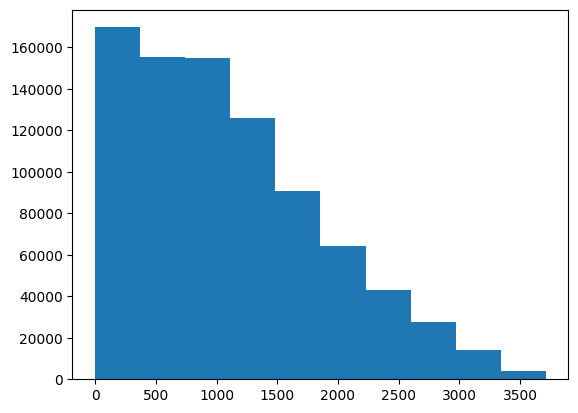

In [4]:
# distribution of cyclones that are close to land - distance from land

plt.hist(ds_summer.min_dist_to_land)

In [5]:
# pick out all the cyclones that are within 500 km of land

ds_summer_ocean = ds_summer.isel(TIME=ds_summer.min_dist_to_land>500)

In [6]:
ds_summer_ocean = ds_summer_ocean.isel(TIME=ds_summer_ocean.TIME > np.datetime64('1981-12-01T00:00:00'))

In [7]:
# storm number count before land removal of storms
print('all storms:', np.unique(ds_summer.STORM_ID).size)

# storm number count where ocean only storms
print('ocean storms:', np.unique(ds_summer_ocean.STORM_ID).size)

all storms: 14895
ocean storms: 13774


In [ ]:
fig = plt.figure(figsize=(8, 7))

ax = fig.add_subplot(projection=ccrs.SouthPolarStereo())

ax = southern_ocean_map(ax)

ax.scatter(land_lons, land_lats, s=0.1, c='tab:blue', transform=ccrs.PlateCarree())

ax.scatter(ds_summer_ocean.LONGITUDE, ds_summer_ocean.LATITUDE, s=1, alpha=0.2, lw=0, c='tab:purple', transform=ccrs.PlateCarree())

In [445]:
var = ['winds', 'sea_ice_cover', '2m_temperature']

data_directory_in  = '/Volumes/LaCie/Work/data/era5/DJF_1981_2023_hourly_means/DJF_1981_2023_' + var[2] +'/*.nc'

file_list = sorted(glob(data_directory_in))

years = np.arange(1981, 1982)

for y in tqdm(range(years.size)):

    year = years[y]
    print(year)

    D = str(year) + '12.nc'
    J = str(year+1) + '01.nc'
    F = str(year+1) + '02.nc'
    
    # choose only the files that are dec, jan or feb
    filtered_files = [file for file in file_list if file.endswith(D) or file.endswith(J) or file.endswith(F)]

    ds = xr.open_mfdataset(filtered_files)

    ds = ds.sel(latitude=slice(-30, -90)).load()

# ds['ws'] = (('time', 'latitude', 'longitude'), np.sqrt(ds.u10.data**2 + ds.v10.data**2))

  0%|          | 0/1 [00:00<?, ?it/s]

1981


In [446]:
# convert longitudes
ds_adjusted = adjust_lon_xr_dataset(ds)

In [10]:
ds_summer_ocean_season = ds_summer_ocean.isel(TIME=((ds_summer_ocean.TIME > np.datetime64('1981-12-01')) & (ds_summer_ocean.TIME < np.datetime64('1982-03-01'))))

In [443]:
ds

<xarray.Dataset>
Dimensions:              (longitude: 1440, latitude: 241, time: 2160)
Coordinates:
  * longitude            (longitude) float32 0.0 0.25 0.5 ... 359.2 359.5 359.8
  * latitude             (latitude) float32 -30.0 -30.25 -30.5 ... -89.75 -90.0
  * time                 (time) datetime64[ns] 1981-12-01 ... 1982-02-28T23:0...
Data variables:
    u10                  (time, latitude, longitude) float32 -1.351 ... 0.5227
    v10                  (time, latitude, longitude) float32 3.957 ... 0.221
    ws                   (time, latitude, longitude) float32 4.182 ... 0.5675
    _longitude_adjusted  (longitude) float32 0.0 0.25 0.5 ... -0.75 -0.5 -0.25
    latitude_radians     (latitude) float32 -0.5236 -0.528 ... -1.566 -1.571
    longitude_radians    (longitude) float32 0.0 0.004363 ... 6.274 6.279
Attributes:
    Conventions:  CF-1.6
    history:      2023-12-15 08:58:04 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [ ]:
# find the radial array of the storm and create a map 

ds_test = ds_summer_ocean_season.isel(TIME=np.arange(2))

radial_idx = np.ndarray([ds_test.TIME.size, 61, 241])
distances = np.ndarray([ds_test.TIME.size, 61, 241])
which_lon_grid = np.ndarray([ds_test.TIME.size])
lons = np.ndarray([ds_test.TIME.size, 241])
lats = np.ndarray([ds_test.TIME.size, 61])

ds['latitude_radians'] = (('latitude'), np.radians(ds['latitude'].data))
ds['longitude_radians'] = (('longitude'), np.radians(ds['longitude'].data))

ds_adjusted['latitude_radians'] = (('latitude'), np.radians(ds_adjusted['latitude'].data))
ds_adjusted['longitude_radians'] = (('longitude'), np.radians(ds_adjusted['longitude'].data))

radius=800

for time_idx, time in tqdm(enumerate(ds_test.TIME.values)):

    cyclone = ds_test.isel(TIME=time_idx) # choose one cyclone position at a time

    if ((cyclone.LONGITUDE > 150) or (cyclone.LONGITUDE < -150)):

        ref_lon = convert_longitude(cyclone.LONGITUDE.values)
        ref_lat = cyclone.LATITUDE.values

        ds_ = ds.sel(time=cyclone.TIME.values, 
                     latitude=slice(np.round(ref_lat) + 7.5, np.round(ref_lat) - 7.5),
                     longitude=slice(np.round(ref_lon) - 30, np.round(ref_lon) + 30)
                     )
        
        which_lon_grid[time_idx] = 1 # give a value that represents a grid of 0 to 360

    else:

        ref_lon = cyclone.LONGITUDE.values
        ref_lat = cyclone.LATITUDE.values   

        ds_ = ds_adjusted.sel(time=cyclone.TIME.values, 
                              latitude=slice(np.round(ref_lat) + 7.5, np.round(ref_lat) - 7.5),
                              longitude=slice(np.round(ref_lon) - 30, np.round(ref_lon) + 30)
                              )   

        which_lon_grid[time_idx] = 0 # give a value that represents a grid of -180 to 180                

    lats[time_idx] = ds_.latitude.values
    lons[time_idx] = ds_.longitude.values

    radial_idx[time_idx], distances[time_idx] = get_idx_cyclone(lats=ds_['latitude_radians'].values, lons=ds_['longitude_radians'].values, ref_lat=np.radians(ref_lat), ref_lon=np.radians(ref_lon), radius=radius)

0it [00:00, ?it/s]

In [312]:
# find the radial array of the storm and create a map 

import gsw

ds_test = ds_summer_ocean_season.isel(TIME=np.arange(2))

radial_idx = np.zeros([ds_test.TIME.size, 61, 241])*np.NaN
distances = np.zeros([ds_test.TIME.size, 61, 241])
which_lon_grid = np.ndarray([ds_test.TIME.size])
lons = np.ndarray([ds_test.TIME.size, 241])
lats = np.ndarray([ds_test.TIME.size, 61])

ds['latitude_radians'] = (('latitude'), np.radians(ds['latitude'].data))
ds['longitude_radians'] = (('longitude'), np.radians(ds['longitude'].data))

ds_adjusted['latitude_radians'] = (('latitude'), np.radians(ds_adjusted['latitude'].data))
ds_adjusted['longitude_radians'] = (('longitude'), np.radians(ds_adjusted['longitude'].data))

radius=800

for time_idx, time in tqdm(enumerate(ds_test.TIME.values)):

    cyclone = ds_test.isel(TIME=time_idx) # choose one cyclone position at a time

    if ((cyclone.LONGITUDE > 150) or (cyclone.LONGITUDE < -150)):

        ref_lon = convert_longitude(cyclone.LONGITUDE.values)
        ref_lat = cyclone.LATITUDE.values

        ds_ = ds.sel(time=cyclone.TIME.values, 
                     latitude=slice(np.round(ref_lat) + 7.5, np.round(ref_lat) - 7.5),
                     longitude=slice(np.round(ref_lon) - 30, np.round(ref_lon) + 30)
                     )
        
        which_lon_grid[time_idx] = 1 # give a value that represents a grid of 0 to 360

    else:

        ref_lon = cyclone.LONGITUDE.values
        ref_lat = cyclone.LATITUDE.values   

        ds_ = ds_adjusted.sel(time=cyclone.TIME.values, 
                              latitude=slice(np.round(ref_lat) + 7.5, np.round(ref_lat) - 7.5),
                              longitude=slice(np.round(ref_lon) - 30, np.round(ref_lon) + 30)
                              )   

        which_lon_grid[time_idx] = 0 # give a value that represents a grid of -180 to 180                

    lats[time_idx] = ds_.latitude.values
    lons[time_idx] = ds_.longitude.values

    # Update the array with ones where the distance is within 500 km
    for i in range(len(lats[time_idx])):
        for j in range(len(lons[time_idx])):
            distances[time_idx,i,j] = gsw.distance([ref_lon, lons[time_idx][j]], [ref_lat, lats[time_idx][i]])/1000
            if distances[time_idx,i,j] <= radius:
                radial_idx[time_idx,i,j] = 1   

0it [00:00, ?it/s]

/var/folders/v4/3lf8sz_n06jf5z94ng5n_mnh0000gp/T/ipykernel_3445/3594834073.py:55: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  distances[time_idx,i,j] = gsw.distance([ref_lon, lons[time_idx][j]], [ref_lat, lats[time_idx][i]])/1000


<xarray.Dataset>
Dimensions:           (TIME: 24)
Coordinates:
  * TIME              (TIME) datetime64[ns] 1981-12-01T01:00:00 ... 1981-12-02
Data variables:
    STORM_ID          (TIME) int64 1711 1711 1711 1711 ... 1711 1711 1711 1711
    LONGITUDE         (TIME) float64 ...
    LATITUDE          (TIME) float64 ...
    PRESSURE_MIN      (TIME) float64 ...
    min_dist_to_land  (TIME) float64 959.7 955.8 949.2 ... 1.047e+03 1.06e+03
Attributes:
    dataset:        Southern Ocean Extratropical Cyclone Tracks
    data source:    https://github.com/jlodise/JGR2022_ExtratropicalCycloneTr...
    method:         Lodise et al. 2022 - Global Climatology of Extratropical ...
    original data:  ERA5 (https://www.ecmwf.int/en/forecasts/datasets/reanaly...

In [431]:
import gsw
from scipy.interpolate import griddata

var = 'ws'

new_x = np.arange(-1000, 1050, 50)
new_y = np.arange(-1000, 1050, 50)

# find the radial array of the storm and create a map 

storm_id = np.unique(ds_summer_ocean_season.STORM_ID)[0]

ds_test = ds_summer_ocean_season.isel(TIME=ds_summer_ocean_season.STORM_ID==storm_id)

new_data = np.ndarray([ds_test.TIME.size, 81, new_x.size])
final_data = np.ndarray([ds_test.TIME.size, new_x.size, new_y.size])  

which_lon_grid = np.ndarray([ds_test.TIME.size])
lons = np.ndarray([ds_test.TIME.size, 241])
lats = np.ndarray([ds_test.TIME.size, 81])

for time_idx, time in tqdm(enumerate(ds_test.TIME.values)):

    cyclone = ds_test.isel(TIME=time_idx) # choose one cyclone position at a time

    if ((cyclone.LONGITUDE > 150) or (cyclone.LONGITUDE < -150)):

        ref_lon = convert_longitude(cyclone.LONGITUDE.values)
        ref_lat = cyclone.LATITUDE.values

        ds_ = ds.sel(time=cyclone.TIME.values, 
                     latitude=slice(np.round(ref_lat) + 10, np.round(ref_lat) - 10),
                     longitude=slice(np.round(ref_lon) - 30, np.round(ref_lon) + 30)
                     )
        
        which_lon_grid[time_idx] = 1 # give a value that represents a grid of 0 to 360

    else:

        ref_lon = cyclone.LONGITUDE.values
        ref_lat = cyclone.LATITUDE.values   

        ds_ = ds_adjusted.sel(time=cyclone.TIME.values, 
                              latitude=slice(np.round(ref_lat) + 10, np.round(ref_lat) - 10),
                              longitude=slice(np.round(ref_lon) - 30, np.round(ref_lon) + 30)
                              )   

        which_lon_grid[time_idx] = 0 # give a value that represents a grid of -180 to 180                

    lats[time_idx] = ds_.latitude.values
    lons[time_idx] = ds_.longitude.values

    # longitude to distance interpolation

    data = ds_[var]        

    dist_from_lon = np.zeros([81, 241])    

    for j, lt in enumerate(lats[time_idx]):    

        for i, ln in enumerate(lons[time_idx]):    

            dist_from_lon[j,i] = gsw.distance([ln, ref_lon], [lt, lt])/1000    

        dist_from_lon[j][lons[time_idx]<ref_lon] = -dist_from_lon[j][lons[time_idx]<ref_lon]    

        new_data[time_idx, j,:] = griddata(dist_from_lon[j], data[j], new_x)    

    # latitude to distance interpolation    

    dist_from_lat = np.zeros([lats[time_idx].size])    

    for j, lt in enumerate(lats[time_idx]):    

        dist_from_lat[j] = gsw.distance([lons[time_idx][0], lons[time_idx][0]], [lt, ref_lat])/1000    

    dist_from_lat[lats[time_idx]<ref_lat] = -dist_from_lat[lats[time_idx]<ref_lat]      

    for i, x in enumerate(new_x):
        
        final_data[time_idx, :,i] = griddata(dist_from_lat, new_data[time_idx, :,i], new_y)
    

0it [00:00, ?it/s]

/var/folders/v4/3lf8sz_n06jf5z94ng5n_mnh0000gp/T/ipykernel_3445/1326888465.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dist_from_lon[j,i] = gsw.distance([ln, ref_lon], [lt, lt])/1000
/var/folders/v4/3lf8sz_n06jf5z94ng5n_mnh0000gp/T/ipykernel_3445/1326888465.py:75: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dist_from_lat[j] = gsw.distance([lons[time_idx][0], lons[time_idx][0]], [lt, ref_lat])/1000


In [434]:
# Define the threshold distance (radius) in km
threshold_distance = 800

# Get the dimensions of the array
rows = len(new_y)
cols = len(new_x)

# Calculate the center point
center_x = rows // 2
center_y = cols // 2

# Create a new 2D array to store the result
radial_idx = np.zeros((rows, cols), dtype=int)*np.NaN

# Iterate through the 2D array
for i in range(rows):
    for j in range(cols):
        # Calculate the distance from the center point
        distance = np.sqrt((new_x[i] - new_x[center_x])**2 + (new_y[j] - new_y[center_y])**2)
        # Check if the distance is within the threshold
        if distance <= threshold_distance:
            radial_idx[i][j] = 1

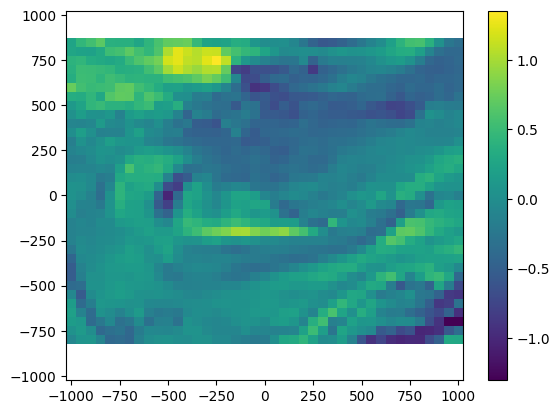

In [390]:
plt.pcolormesh(new_x, new_y, final_data[3]-final_data[2])
plt.colorbar()

MovieWriter ffmpeg unavailable; using Pillow instead.


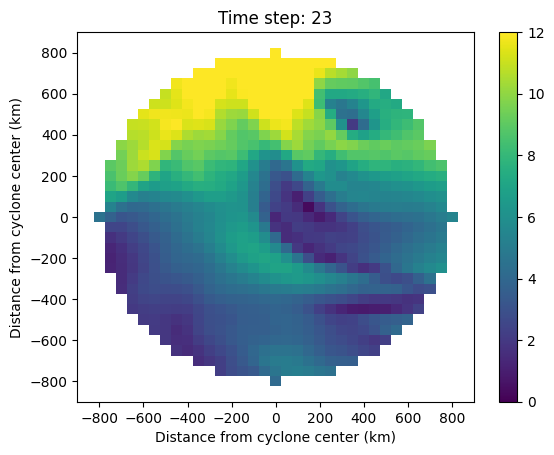

In [441]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Sample 3D array (time, lat, lon) with random data for demonstration purposes
time_steps = 24

# Create a figure and axis for the animation
fig, ax = plt.subplots()

# Function to update the plot for each frame
def update(frame):
    ax.clear()
    img = ax.pcolormesh(new_x, new_y, final_data[frame]*radial_idx, cmap='viridis', vmin=0, vmax=10)
    ax.set_title(f'Time step: {frame}')
    ax.set_xlabel('Distance from cyclone center (km)')
    ax.set_ylabel('Distance from cyclone center (km)')
    ax.set_xlim(-900, 900); ax.set_ylim(-900, 900)
    # ax.contour(new_x, new_y, radial_idx, levels=np.arange(0,1), colors='k')
    return img,

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=range(time_steps), blit=True) 

# Add colorbar only once
cbar = fig.colorbar(ax.pcolormesh(new_x, new_y, final_data[0], cmap='viridis', vmin=0, vmax=12), ax=ax)

# Save the animation as a video file
ani.save('animation.gif', writer='ffmpeg') # can also save with writer imagemagick

# Display the animation
plt.show()

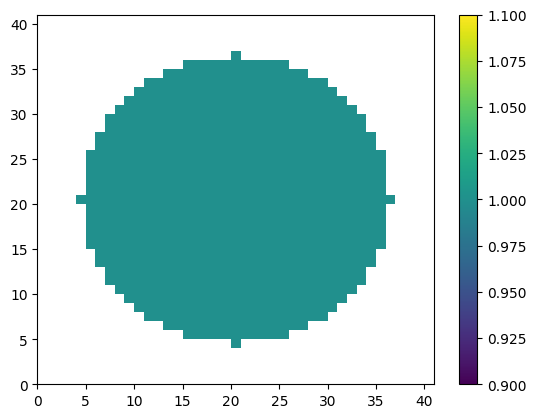

In [438]:
plt.pcolormesh(radial_idx)

plt.colorbar()

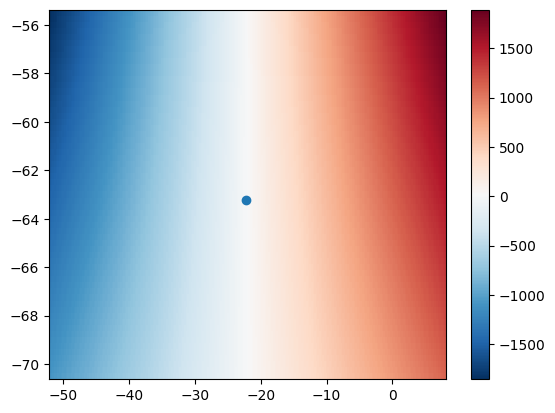

In [347]:
plt.pcolormesh(lons[1], lats[1], dist_from_lon, cmap='RdBu_r')
plt.colorbar()
plt.scatter(ref_lon, ref_lat)

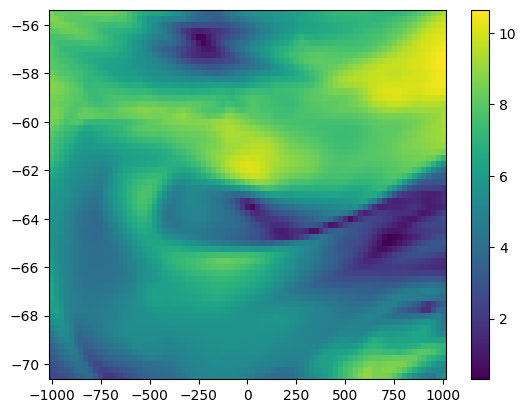

In [ ]:

plt.pcolormesh(new_x, lats[1], new_data)
plt.colorbar()

In [352]:
dist_from_lat = np.zeros([lats[1].size])

for j, lt in enumerate(lats[1]):

    dist_from_lat[j] = gsw.distance([lons[1][0], lons[1][0]], [lt, ref_lat])/1000

dist_from_lat[lats[1]<ref_lat] = -dist_from_lat[lats[1]<ref_lat]

final_data = np.ndarray([new_x.size, new_y.size])

for i, x in enumerate(new_x):
    
    final_data[:,i] = griddata(dist_from_lat, new_data[:,i], new_y)
    

/var/folders/v4/3lf8sz_n06jf5z94ng5n_mnh0000gp/T/ipykernel_3445/3543312833.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dist_from_lat[j] = gsw.distance([lons[1][0], lons[1][0]], [lt, ref_lat])/1000


In [356]:
dist_from_lat.max()

858.515399699594

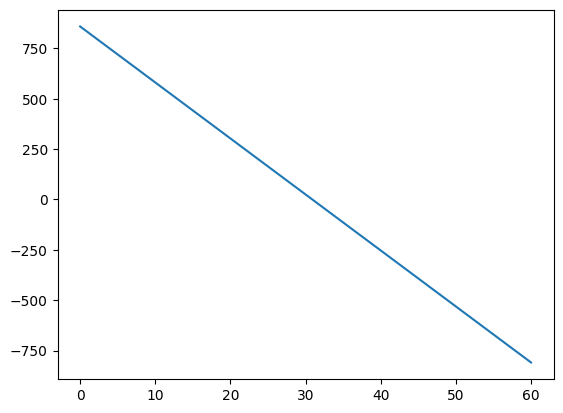

In [ ]:
plt.plot(dist_from_lat)

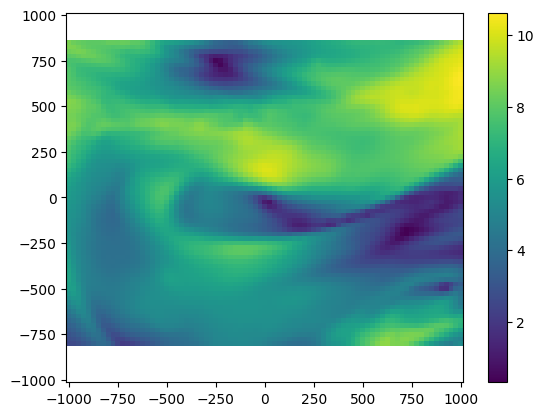

In [353]:
plt.pcolormesh(new_x, new_y, final_data)
plt.colorbar()

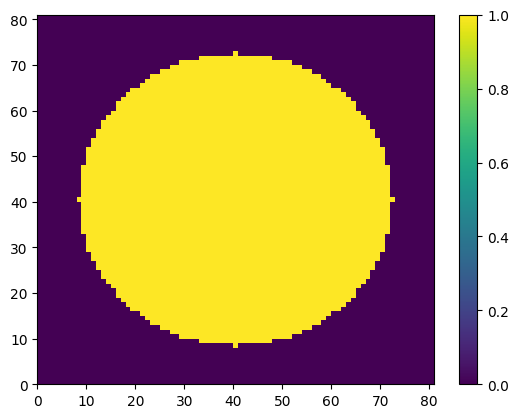

In [368]:
plt.pcolormesh(result)
plt.colorbar()


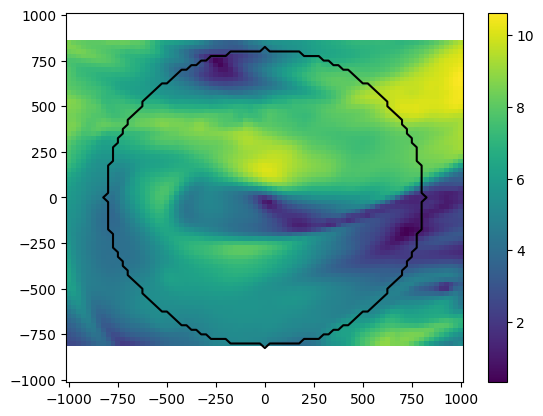

In [369]:
plt.pcolormesh(new_x, new_y, final_data)
plt.colorbar()
plt.contour(new_x, new_y, result, levels=[0,1], colors='k')

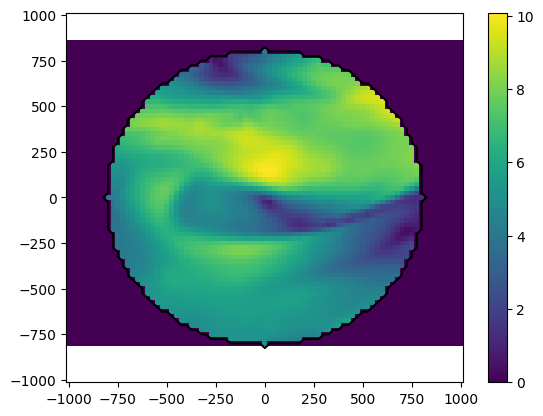

In [370]:
plt.pcolormesh(new_x, new_y, final_data*result)
plt.colorbar()
plt.contour(new_x, new_y, result, levels=[0,1], colors='k')

In [ ]:
import gsw
from scipy.interpolate import griddata

# data = radial_idx[1]*ds_['ws']

data = distances[1]

new_x = np.arange(-1000, 1025, 25)
new_y = np.arange(-1000, 1025, 25)

new_data = np.ndarray([lats[1].size, new_x.size])

for j, lt in enumerate(lats[1]):

    new_lon = np.empty(0)

    for i, ln in enumerate(lons[1]):

        new_lon = np.append(new_lon, gsw.distance([lons[1][i], ref_lon], [lats[1][j], lats[1][j]])/1000)

    new_lon[lons[1]<ref_lon] = -new_lon[lons[1]<ref_lon]

    new_data[j,:] = griddata(new_lon, data[j,:], new_x)

final_data = np.ndarray([new_x.size, new_y.size])

new_lat = np.empty(0)

for i, lt in enumerate(lats[1]):

    new_lat = np.append(new_lat, gsw.distance([lons[1][0], lons[1][0]], [lats[1][i], ref_lat])/1000)

new_lat[lats[1]<ref_lat] = -new_lat[lats[1]<ref_lat]

for i, ln in enumerate(new_x):

    final_data[:,i] = griddata(new_lat, new_data[:,i], new_y)

In [328]:
new_lon

array([-1091.80979906, -1082.80519123, -1073.79595954, -1064.78214318,
       -1055.76378137, -1046.74091331, -1037.71357821, -1028.68181529,
       -1019.64566375, -1010.60516281, -1001.56035168,  -992.51126958,
        -983.45795572,  -974.40044933,  -965.33878961,  -956.2730158 ,
        -947.20316711,  -938.12928277,  -929.05140199,  -919.969564  ,
        -910.88380803,  -901.7941733 ,  -892.70069904,  -883.60342447,
        -874.50238882,  -865.39763133,  -856.28919121,  -847.1771077 ,
        -838.06142004,  -828.94216745,  -819.81938917,  -810.69312442,
        -801.56341244,  -792.43029247,  -783.29380374,  -774.15398548,
        -765.01087693,  -755.86451733,  -746.71494592,  -737.56220192,
        -728.40632458,  -719.24735313,  -710.08532682,  -700.92028488,
        -691.75226655,  -682.58131107,  -673.40745769,  -664.23074563,
        -655.05121414,  -645.86890247,  -636.68384985,  -627.49609552,
        -618.30567872,  -609.11263871,  -599.91701471,  -590.71884598,
      

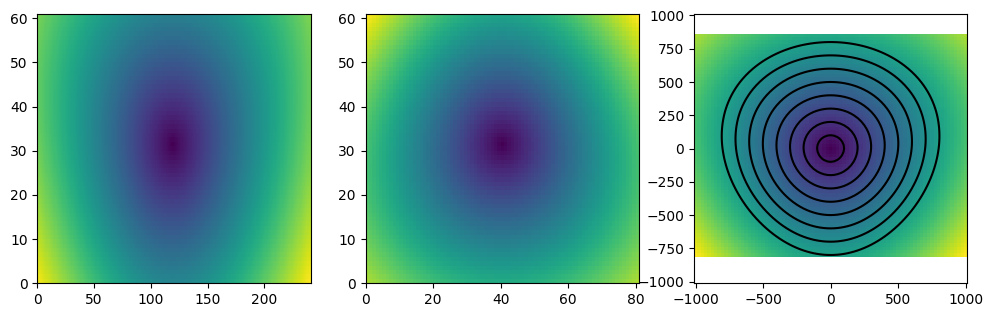

In [327]:
fig,ax=plt.subplots(1,3,figsize=(12,3.5))

ax[0].pcolormesh(data)
ax[1].pcolormesh(new_data)
ax[2].pcolormesh(new_x, new_y, final_data)
ax[2].contour(new_x, new_y, final_data, levels=np.arange(0, 900, 100), colors='k')

(-80.0, -30.0)

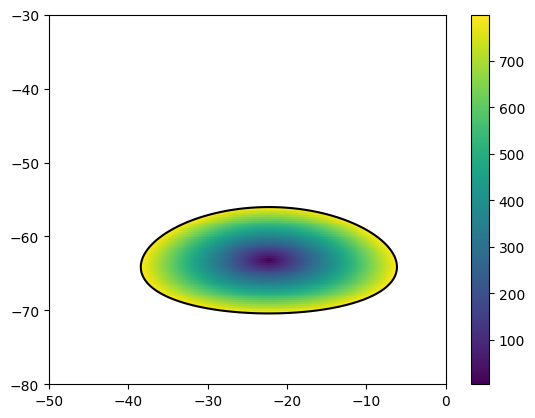

In [297]:
plt.pcolormesh(lons[1], lats[1], distances[1]*radial_idx[1])
plt.colorbar()
plt.contour(lons[1], lats[1], distances[1], levels=[0,800], colors='k')

plt.xlim(-50, 0)
plt.ylim(-80, -30)


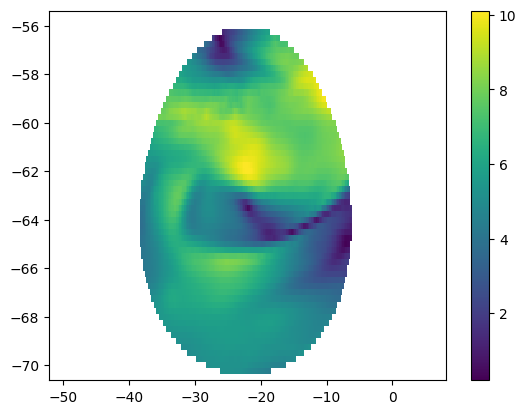

In [298]:
plt.pcolormesh(lons[1], lats[1], radial_idx[1]*ds_['ws'])
plt.colorbar()
# plt.contour(lons[1], lats[1], distances[1], levels=[0,800], colors='k')


In [211]:
distances_test = distances[1]
distances_test[:120] = -distances_test[:120]

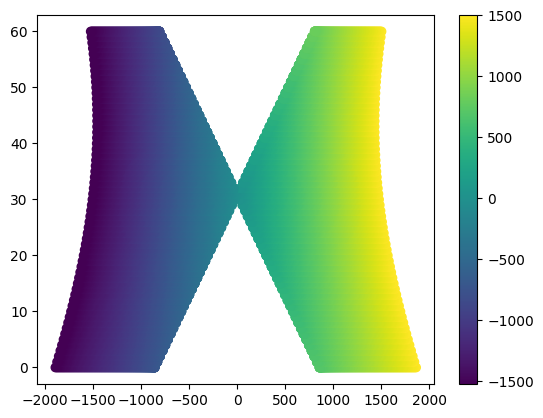

In [143]:
for i in range(61):

    plt.scatter(distances_test[i,:], np.tile(i, 241), c=distances_test[i,:])

plt.colorbar()

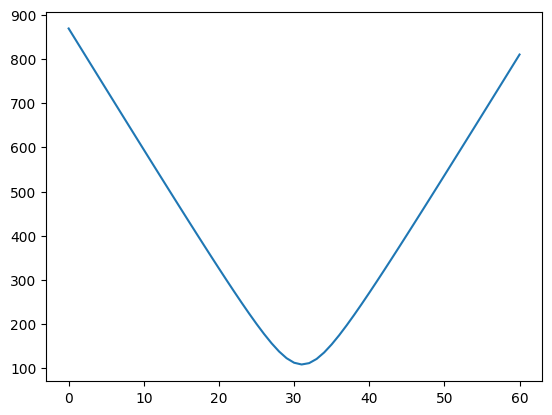

In [130]:
plt.plot(distances[0,:,130])

In [63]:
idx_lt=lats[1]<ref_lat
idx_ln=lons[1]<ref_lon

In [97]:
dist_array_new = distances[1]
dist_array_new[:,idx_ln] = -dist_array_new[:,idx_ln]

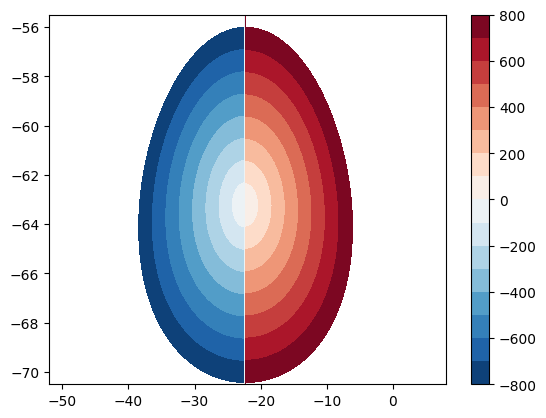

In [100]:
plt.contourf(lons[1], lats[1], dist_array_new, levels=np.arange(-800, 900, 100), cmap='RdBu_r')
plt.colorbar()
#plt.contour(lons[1], lats[1], dist_array[1], levels=np.arange(-800, 900, 100), colors='k')
plt.show()

In [131]:
ws = ds_['ws']*radial_idx[1]

In [132]:
ws.shape

(61, 241)

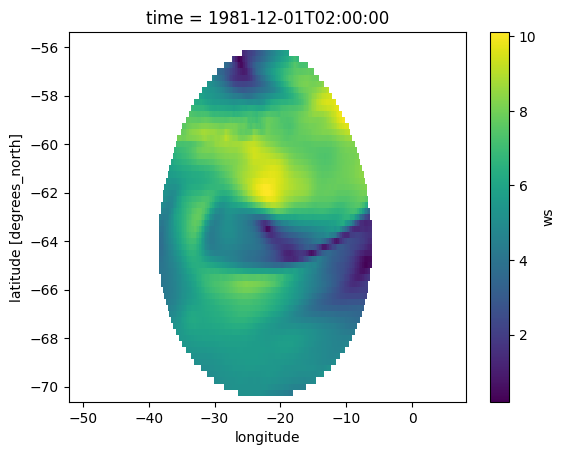

In [104]:
ws.plot()

In [123]:
from scipy.interpolate import griddata

distance_x = np.arange(-1000, 1050, 50)

new_ws = np.ndarray([61, distance_x.size])

for i in range(61):
    
    new_ws[i] = griddata(dist_array_new[i], ws[i], distance_x)

/var/folders/v4/3lf8sz_n06jf5z94ng5n_mnh0000gp/T/ipykernel_3445/1718128660.py:1: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(distance_x, dist_array_new[:,i],new_ws)


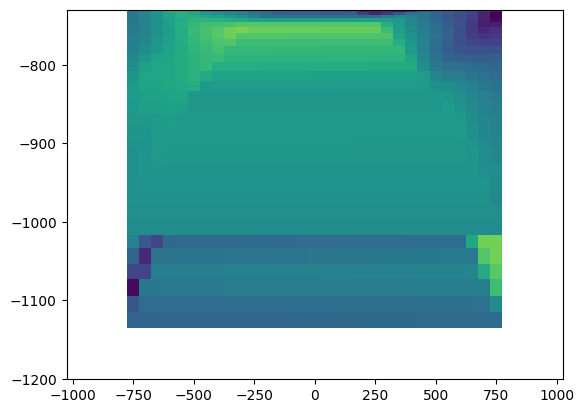

In [124]:
plt.pcolormesh(distance_x, dist_array_new[:,i],new_ws)


In [93]:
import numpy as np
import xarray as xr
from geopy.distance import geodesic

def calculate_distance(lon1, lat1, lon2, lat2):
    return geodesic((lat1, lon1), (lat2, lon2)).km

def extract_within_radius(data, central_lon, central_lat, radius_km):
    lons, lats = np.meshgrid(data.longitude, data.latitude)
    distances = np.vectorize(calculate_distance)(central_lon, central_lat, lons, lats)
    mask = distances <= radius_km
    print(mask.shape)
    return data.where(mask, drop=True), distances

# Load ERA5 wind speed data (assuming the file is named 'era5_wind_speed.nc')
data = ds_['ws']

# Define the central coordinate and radius
central_lon = ref_lon  # Example: Vancouver longitude
central_lat = ref_lat    # Example: Vancouver latitude
radius_km = 800

# Extract data within the specified radius
extracted_data,distances = extract_within_radius(data, central_lon, central_lat, radius_km)

(61, 241)


TypeError: cond argument is array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]) but must be a <class 'xarray.core.dataset.Dataset'> or <class 'xarray.core.dataarray.DataArray'>

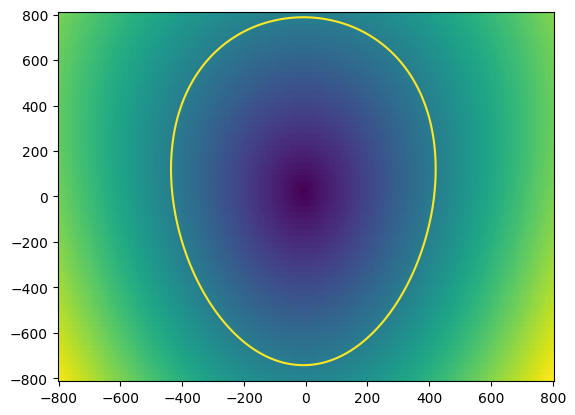

In [92]:
plt.pcolormesh(X, Y, distances)

plt.contour(X, Y, distances, levels=[0,800])

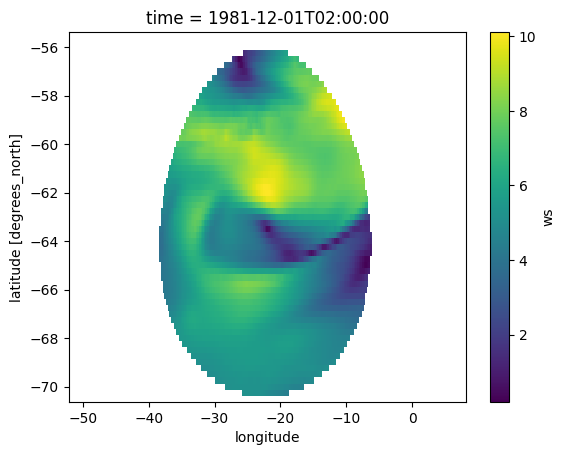

In [84]:
extracted_data.plot()

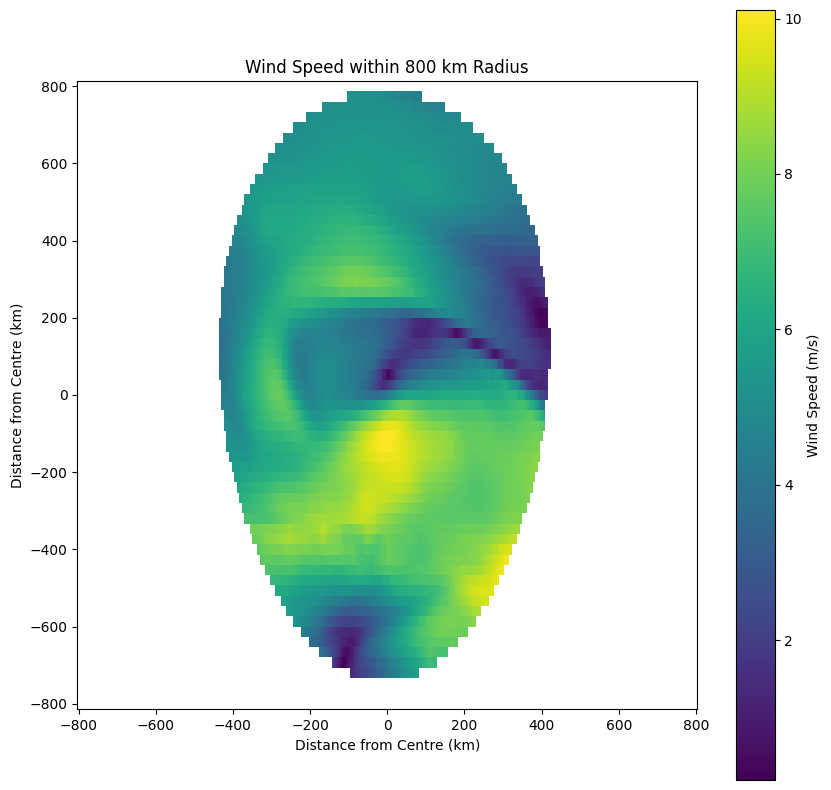

In [86]:
# Create a meshgrid for the distances from the center
x_distances = np.linspace(-radius_km, radius_km, distances.shape[1])
y_distances = np.linspace(-radius_km, radius_km, distances.shape[0])
X, Y = np.meshgrid(x_distances, y_distances)

# Plot the extracted data using pcolormesh
plt.figure(figsize=(10, 10))
plt.pcolormesh(X, Y, extracted_data)
plt.colorbar(label='Wind Speed (m/s)')
plt.xlabel('Distance from Centre (km)')
plt.ylabel('Distance from Centre (km)')
plt.title('Wind Speed within 800 km Radius')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [ ]:
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

# Ensure the values array matches the shape of the lon/lat grid
lon_grid, lat_grid = np.meshgrid(ds_.longitude-cyclone.LONGITUDE, ds_.latitude)

# Convert lon/lat to Cartesian coordinates (x, y)
def lonlat_to_cartesian(lon, lat):
    R = 6371  # Earth radius in kilometers
    x = R * np.radians(lon) * np.cos(np.radians(lat))
    y = R * np.radians(lat)
    return x, y

x, y = lonlat_to_cartesian(lon_grid, lat_grid)

# Flatten the x, y, and values arrays
points = np.array([x.flatten(), y.flatten()]).T
values_flat = (dist_array[1]).flatten()

# Create a distance grid
distance_grid_x, distance_grid_y = np.meshgrid(np.linspace(min(x.flatten()), max(x.flatten()), 100), 
                                               np.linspace(min(y.flatten()), max(y.flatten()), 100))

# Interpolate the 2D array to the distance grid
grid_z = griddata(points, values_flat, (distance_grid_x, distance_grid_y), method='linear')

# Plotting (optional)
# plt.imshow(grid_z, extent=(min(x.flatten()), max(x.flatten()), min(y.flatten()), max(y.flatten())), origin='lower')
plt.pcolormesh(distance_grid_x, distance_grid_y, grid_z)
plt.contour(distance_grid_x, distance_grid_y, grid_z, levels=np.arange(0, 900, 100), colors='k')
plt.colorbar()
plt.xlim(-2000, 2000)
plt.ylim(-9000, -5000)
plt.show()

plt.pcolormesh(ds_.longitude, ds_.latitude, dist_array[1])
plt.contour(ds_.longitude, ds_.latitude, dist_array[1])




In [ ]:
plt.pcolormesh(lat_grid)
plt.colorbar()

In [ ]:
for time_idx, time in tqdm(enumerate(ds_test.TIME.values)):

    cyclone = ds_test.isel(TIME=time_idx)

    # convert the cyclone latitude and longitude values to radians for faster processesing
    cyclone_lat = np.radians(cyclone.LATITUDE)
    cyclone_lon = np.radians(cyclone.LONGITUDE)

    # convert the ERA5 latitude and longitude values to radians for faster processesing
    lons_rad = np.radians(lons)
    lats_rad = np.radians(lats)

    # initialise an empty array of the size of the distance_x
    dlon_to_cyclone = np.ndarray([lats_rad[time_idx].size, lons_rad[time_idx].size])
    dlat_to_cyclone = np.ndarray([lats_rad[time_idx].size])

    # iterate through the latitude radians values
    for i, lt in enumerate(lats_rad[time_idx]):

        # iterate throug the ERA5 latitudes and find the distance btween the latitude value and the cyclone latitude
        dlat_to_cyclone[i] = haversine_rad(lat1=cyclone_lat, lon1=cyclone_lon, lat2=lt, lon2=cyclone_lon)

        # iterate through the ERA5 longitude values, finding the distance between the given longitude value and the centre of the cyclone
        for j, ln in enumerate(lons_rad[time_idx]):
            dlon_to_cyclone[i,j] = haversine_rad(lat1=lt, lon1=cyclone_lon, lat2=lt, lon2=ln) 

        idx = np.argmin(dlon_to_cyclone[i])
        dlon_to_cyclone[i][:idx] = -dlon_to_cyclone[i][:idx]

    idx = np.argmin(dlat_to_cyclone)
    dlat_to_cyclone[:idx] = -dlat_to_cyclone[:idx]

In [ ]:
from scipy.interpolate import griddata

dlon = np.arange(-900, 925, 25)

dist_array_interp = np.ndarray([dlat_to_cyclone.size, dlon.size])

for i, lt in enumerate(dlat_to_cyclone):

    dist_array_interp[i] = griddata(dlon_to_cyclone[i], radius_array[1,i,:]*dist_array[1,i,:], dlon)

dist_array_interp_both = np.ndarray([dlon.size, dlon.size])
 
for i in range(dlon.size):
 
    dist_array_interp_both[:,i] = griddata(dlat_to_cyclone, dist_array_interp[:,i], dlon)

In [ ]:
fig,ax=plt.subplots(1,1, figsize=(5,5))

#ax.pcolormesh(dlon, dlat_to_cyclone, dist_array_interp)

ax.contour(dlon, dlon, dist_array_interp_both, levels=np.arange(0, 900, 100), colors='k')

ax.set_xlim(-900, 900)
ax.set_ylim(-900, 900)

ax.plot([0, 0], [-800, 800])
ax.plot([-800, 800], [0, 0])

ax.plot([-800, 800], [400, 400])
ax.plot([-800, 800], [-400, -400])
ax.plot([320, 320], [-800, 800])
ax.plot([-320, -320], [-800, 800])

In [ ]:
fig,ax=plt.subplots(1,2, figsize=(10,5))

ax[0].pcolormesh(dlon_to_cyclone[30], dlat_to_cyclone, radius_array[1]*dist_array[1])
ax[1].pcolormesh(dlon, dlat_to_cyclone, dist_array_interp)

for a in ax:

    a.set_xlim(-900, 900)
    a.set_ylim(-900, 900)

In [ ]:
plt.pcolormesh(dist_array[0]*radius_array[0])

In [ ]:
grid_z.shape

In [ ]:
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

# Ensure the values array matches the shape of the lon/lat grid
lon_grid, lat_grid = np.meshgrid(lons[0], lats[0])

# Convert lon/lat to Cartesian coordinates (x, y)
def lonlat_to_cartesian(lon, lat):
    R = 6371  # Earth radius in kilometers
    x = R * np.radians(lon) * np.cos(np.radians(lat))
    y = R * np.radians(lat)
    return x, y

x, y = lonlat_to_cartesian(lon_grid, lat_grid)

# Flatten the x, y, and values arrays
points = np.array([x.flatten(), y.flatten()]).T
values_flat = (dist_array[0]*radius_array[0]).flatten()

# Create a distance grid
distance_grid_x, distance_grid_y = np.meshgrid(np.linspace(min(x.flatten()), max(x.flatten()), 100), 
                                               np.linspace(min(y.flatten()), max(y.flatten()), 100))

# Interpolate the 2D array to the distance grid
grid_z = griddata(points, values_flat, (distance_grid_x, distance_grid_y), method='linear')

# Plotting (optional)
plt.imshow(grid_z, extent=(min(x.flatten()), max(x.flatten()), min(y.flatten()), max(y.flatten())), origin='lower')
plt.colorbar()
plt.show()

plt.contour(distance_grid_x, distance_grid_y, grid_z)


In [ ]:
ds_test = ds_adjusted.sel(time=time)

In [ ]:
which_lon_grid[1]

In [ ]:
plt.imshow(dlon_to_cyclone, cmap='RdBu_r')
plt.colorbar()

In [ ]:
plt.pcolormesh(lons[1], lats[1], radius_array[1]*dist_array[1])

plt.colorbar()

In [ ]:
plt.pcolormesh(dx, dy, radius_array[-1]*dist_array[-1])
plt.colorbar()
plt.contour(dx, dy, dist_array[-1], levels=[500, 800], colors='k')

# plt.xlim(-800, 800)
# plt.ylim(-800, 800)

# plt.plot([-800, 800], [0, 0])

skip=4

# plt.quiver((radius_array*ds_['u10'])[::skip, ::skip], (radius_array*ds_['v10'])[::skip, ::skip], scale=300)


$$ \text{Distance per degree of longitude} = 111.32 \times \cos(70^\circ) \approx 111.32 \times 0.342 = 38.08 \text{ km} $$

$$ \text{Degrees of longitude} = \frac{800 \text{ km}}{38.08 \text{ km/degree}} \approx 21.01^\circ $$

In [ ]:
800 / (111.32*np.cos(np.deg2rad(74)))

In [ ]:
plt.plot(dist_array[2,0])
plt.plot(dist_array[20,0])

In [ ]:
plt.imshow(radius_array*ds_['ws'])

In [ ]:
(radius_array*ds_['ws'])

In [ ]:
points.shape

In [ ]:
values.shape

In [ ]:
from scipy.interpolate import griddata

new_x = np.arange(-800, 820, 20)

new_z = np.ndarray([61, new_x.size])
new_z2 = np.ndarray([new_x.size, new_x.size])

for i in range(61):

    new_z[i] = griddata(dist_array[i], (radius_array*ds_['ws'].values)[i], new_x)

for i in range(new_z.size):

    new_z2[:,i] = griddata(dist_array[:,i], new_z[:,i], new_x)   

In [ ]:
dist_array.shape

In [ ]:
new_z.shape

In [ ]:
distance_x.size

In [ ]:
distance_y.size

In [ ]:
from scipy.interpolate import griddata

points = dist_array # shape (61,101)
values = (radius_array*ds_['ws'].values).ravel() # shape 6161

# points = points[~np.isnan(values)]
# values = values[~np.isnan(values)]

# Define the 1D arrays for the new grid
x = np.arange(-800, 820, 20)
y = np.arange(-800, 820, 20)

# Create the meshgrid from the 1D arrays
grid_x, grid_y = np.meshgrid(x, y)

griddata(points, values, (grid_x, grid_y), method='nearest')

In [ ]:
points

In [ ]:
(radius_array * ds_['ws'])

In [ ]:
points.shape

In [ ]:
from scipy.interpolate import griddata
import numpy as np

# Flatten the arrays
points = dist_array
values_flat = (radius_array * ds_['ws'].values).ravel()

# Define the 1D arrays for the new grid
x_new = np.arange(-800, 820, 20)
y_new = np.arange(-800, 820, 20)

# Create the meshgrid from the 1D arrays
grid_x, grid_y = np.meshgrid(x_new, y_new)

# Interpolate the values onto the new grid
interpolated_values = griddata(points, values_flat, (grid_x, grid_y), method='linear')

In [ ]:
from scipy.interpolate import griddata
import numpy as np

# Example data (replace with your actual data)
dist_array = np.array([
    [0, 1, 2],
    [1, 2, 3],
    [2, 3, 4]
])
radius_array = np.array([
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1]
])
ds_ = {'ws': np.array([
    [10, 20, 30],
    [40, 50, 60],
    [70, 80, 90]
])}

# Flatten the arrays
dist_array_flat = dist_array.ravel()
values_flat = (radius_array * ds_['ws'].values).ravel()

# Remove NaN values
valid_mask = ~np.isnan(values_flat)
dist_array_flat = dist_array_flat[valid_mask]
values_flat = values_flat[valid_mask]

# Create a 2D array of coordinates for the original grid
x_orig, y_orig = np.meshgrid(np.arange(dist_array.shape[1]), np.arange(dist_array.shape[0]))
points = np.column_stack((x_orig.ravel(), y_orig.ravel()))
points = points[valid_mask]

# Define the 1D arrays for the new grid
x_new = np.arange(-800, 820, 20)
y_new = np.arange(-800, 820, 20)

# Create the meshgrid from the 1D arrays
grid_x, grid_y = np.meshgrid(x_new, y_new)

# Interpolate the values onto the new grid
interpolated_values = griddata(points, values_flat, (grid_x, grid_y), method='nearest')

In [ ]:
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

# Define the function to interpolate
def func(x, y):
    return x * (1 - x) * np.cos(4 * np.pi * x) * np.sin(4 * np.pi * y**2)**2

# Generate random data points
rng = np.random.default_rng()
points = rng.random((1000, 2))
values = func(points[:, 0], points[:, 1])

# Define the 1D arrays for the new grid
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)

# Create the meshgrid from the 1D arrays
grid_x, grid_y = np.meshgrid(x, y)

# Perform the interpolation
grid_z = griddata(points, values, (grid_x, grid_y), method='cubic')

# Plot the results
plt.imshow(grid_z.T, extent=(0, 1, 0, 1), origin='lower')
plt.scatter(points[:, 0], points[:, 1], c=values, edgecolors='k', marker='o')
plt.title('Interpolated Data')
plt.colorbar()
plt.show()

In [ ]:
ds_sel

In [ ]:
ds_sel = ds_summer_ocean.isel(TIME=ds_summer_ocean.TIME == sic.time.isel(time=0))

for i in range(ds_sel.TIME.size):
    # Use nearest neighbor interpolation to find the closest grid point
    sea_ice = sic.sel(latitude=ds_sel.LATITUDE.values[i], longitude=ds_sel.LONGITUDE.values[i], method='nearest')['siconc'].values

In [ ]:
sea_ice 

In [ ]:
ds_summer_ocean

In [ ]:
sic

In [ ]:
# let's remove the cyclones where there is sea ice

path = glob('/Volumes/LaCie/Work/data/era5/DJF_1981_2023_hourly_means/DJF_1981_2023_winds/*wind_201012.nc')

wind = xr.open_mfdataset(path).load()

wind['ws'] = (('time', 'latitude', 'longitude'), np.sqrt(wind.u10.data**2 + wind.v10.data**2))

wind = wind.sel(latitude=slice(-40, -90))

In [ ]:
ds_summer_ocean

In [ ]:
# load the era5 wind data

path = glob('/Volumes/LaCie/Work/data/era5/DJF_1981_2023_hourly_means/DJF_1981_2023_winds/*wind_201012.nc')

wind = xr.open_mfdataset(path).load()

wind['ws'] = (('time', 'latitude', 'longitude'), np.sqrt(wind.u10.data**2 + wind.v10.data**2))

wind = wind.sel(latitude=slice(-40, -90))

In [ ]:
# load the era5 shf data

path = glob('/Volumes/LaCie/Work/data/era5/DJF_1981_2023_hourly_means/DJF_1981_2023_sensible_heat_flux/surface_sensible_heat_flux_201012.nc')

shf = xr.open_mfdataset(path).load()

shf = shf.sel(latitude=slice(-40, -90))

In [ ]:
# convert shf to W m-2
shf = convert_era5_to_Wm2(shf, ['sshf'], data_freq='hour')

In [ ]:
# convert longitudes
wind = adjust_lon_xr_dataset(wind)
shf = adjust_lon_xr_dataset(shf)

In [ ]:


# Reference point
#ref_lat = -50.0
#ref_lon = 0.0



In [ ]:
time_idx = 622500

ds_wind = wind.sel(time=ds_summer.isel(TIME=time_idx).TIME.values, method='nearest')
ds_shf = shf.sel(time=ds_summer.isel(TIME=time_idx).TIME.values, method='nearest')

print('wind time', ds_wind.time.values)
print('cyclone time', ds_summer.isel(TIME=time_idx).TIME.values)

ref_lon = ds_summer.isel(TIME=time_idx).LONGITUDE.values
ref_lat = ds_summer.isel(TIME=time_idx).LATITUDE.values

lats = wind.latitude.values
lons = wind.longitude.values

radius=800

radius_array, dist_array, distance_x, distance_y = get_idx_cyclone(lats=lats, lons=lons, ref_lat=ref_lat, ref_lon=ref_lon, radius=radius)

In [ ]:
plt.pcolormesh(distance_x, distance_y, radius_array*ds_wind.ws)
plt.colorbar()

plt.ylim(-radius*1.1, radius*1.1)
plt.xlim(-radius*1.1, radius*1.1)

plt.plot([-radius, radius], [0, 0], c='k', ls='--')
plt.plot([0, 0], [-radius, radius], c='k', ls='--')

skip=4

plt.quiver(distance_x[::skip], distance_y[::skip], (radius_array*ds_wind.u10)[::skip, ::skip], (radius_array*ds_wind.v10)[::skip, ::skip], scale=300)



In [ ]:
plt.pcolormesh(distance_x, distance_y, radius_array*ds_shf.sshf, cmap='RdBu_r', vmin=-50, vmax=50)
plt.colorbar()

plt.ylim(-radius*1.1, radius*1.1)
plt.xlim(-radius*1.1, radius*1.1)

plt.plot([-radius, radius], [0, 0], c='k', ls='--')
plt.plot([0, 0], [-radius, radius], c='k', ls='--')

skip=4

plt.quiver(distance_x[::skip], distance_y[::skip], (radius_array*ds_wind.u10)[::skip, ::skip], (radius_array*ds_wind.v10)[::skip, ::skip], scale=300)



In [ ]:
# Create the xarray Dataset
ds = xr.Dataset(
    {
        'shf': (['distance_y', 'distance_x'], radius_array*ds_shf.sshf.data)
    },
    coords={
        'distance_x': distance_x,
        'distance_y': distance_y
    }
)

In [ ]:
radius_array.shape

In [ ]:
ds_shf.sshf.shape

In [ ]:
idy

In [ ]:
idx = ((distance_x > -900) & (distance_x < 900))
idy = ((distance_y > -900) & (distance_y < 900))

In [ ]:
plt.pcolormesh(distance_x[idx], distance_y[idy], radius_array[idy,:][:,idx]*ds_shf.sshf[idy,:][:,idx], cmap='RdBu_r', vmin=-50, vmax=50)
plt.colorbar()

#plt.ylim(-radius*1.1, radius*1.1)
#plt.xlim(-radius*1.1, radius*1.1)

plt.plot([-radius, radius], [0, 0], c='k', ls='--')
plt.plot([0, 0], [-radius, radius], c='k', ls='--')

skip=4

#plt.quiver(distance_x[::skip], distance_y[::skip], (radius_array*ds_wind.u10)[::skip, ::skip], (radius_array*ds_wind.v10)[::skip, ::skip], scale=300)



In [ ]:
idx.shape

In [ ]:
radius_array[idy,:][:,idx].shape

In [ ]:
ds_shf.sshf

In [ ]:

import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
# Example data with different shapes
x = np.random.rand(10, 10)
y = np.random.rand(10, 10)
z = np.sin(x * 10) * np.cos(y * 10)  # Example function
# Flatten the arrays
x_flat = x.flatten()
y_flat = y.flatten()
z_flat = z.flatten()

new_x = np.linspace(0, 1, 50)
new_y = np.linspace(0, 1, 50)
new_x, new_y = np.meshgrid(new_x, new_y)

new_z = griddata((x_flat, y_flat), z_flat, (new_x, new_y), method='cubic')
plt.figure()
plt.subplot(121)
plt.scatter(x_flat, y_flat, c=z_flat, marker='o')
plt.title('Original Data')
plt.subplot(122)
plt.imshow(new_z, extent=(0, 1, 0, 1), origin='lower')
plt.title('Interpolated Data')
plt.show()

In [ ]:
from scipy.interpolate import griddata

new_x, new_y = np.meshgrid(np.arange(-1000, 1020, 20), np.arange(-1000, 1020, 20))


# Interpolate using griddata
new_z = griddata((distance_x, distance_y), radius_array*ds_shf.sshf, (new_x, new_y), method='cubic')

In [144]:
# trying something new

In [152]:
import numpy as np
from geopy.distance import geodesic

def lon_lat_to_distance(lon, lat, center_lon, center_lat):
    """
    Convert longitude and latitude values to distances (km) from a center point.
    
    Parameters:
    lon (array): Array of longitude values.
    lat (array): Array of latitude values.
    center_lon (float): Longitude of the center point.
    center_lat (float): Latitude of the center point.
    
    Returns:
    distances (array): Array of distances in km from the center point.
    """
    distances = np.zeros(lon.shape)
    
    for i in range(len(lon)):
        for j in range(len(lat)):
            distances[i, j] = geodesic((lat[j], lon[i]), (center_lat, center_lon)).km
    
    return distances

def filter_points_within_radius(lon, lat, center_lon, center_lat, radius):
    """
    Filter points within a given radius from a center point.
    
    Parameters:
    lon (array): Array of longitude values.
    lat (array): Array of latitude values.
    center_lon (float): Longitude of the center point.
    center_lat (float): Latitude of the center point.
    radius (float): Radius in km.
    
    Returns:
    filtered_points (list): List of points within the radius.
    """
    filtered_points = []
    
    for i in range(len(lon)):
        for j in range(len(lat)):
            distance = geodesic((lat[j], lon[i]), (center_lat, center_lon)).km
            if distance <= radius:
                filtered_points.append((lon[i], lat[j]))
    
    return filtered_points

# Example usage
lon = ds_.longitude.values
lat = ds_.latitude.values
center_lon = ref_lon
center_lat = ref_lat
radius = 800

distances = lon_lat_to_distance(lon, lat, center_lon, center_lat)
filtered_points = filter_points_within_radius(lon, lat, center_lon, center_lat, radius)

print("Distances (km) from the center point:")
print(distances)

print("\nPoints within 800 km radius:")
print(filtered_points)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [149]:
ref_lon

array(-22.28936652)

In [150]:
ref_lat

array(-63.22081448)

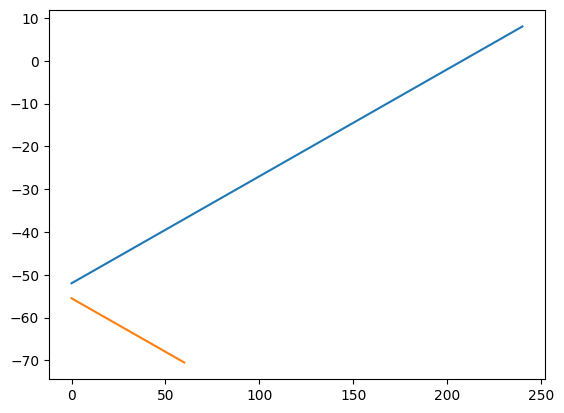

In [148]:
lon = ds_.longitude
lat = ds_.latitude

plt.plot(lon)
plt.plot(lat)